Copyright **`(c)`** 2023 Antonio Ferrigno `<s316467@polito.it>`  
[`https://github.com/s316467/Computational-Intelligence-23-24/tree/main`](https://github.com/s316467/Computational-Intelligence-23-24/tree/main)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/s316467/Computational-Intelligence-23-24/tree/main/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [237]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy


## The *Nim* and *Nimply* classes

In [238]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [239]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self.initial_rows = [i * 2 + 1 for i in range(num_rows)]  # Store the initial configuration
        self._rows = self.initial_rows.copy()  # Start with the initial configuration
        self._k = k


    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        
    def reset(self):
        self._rows = self.initial_rows.copy()

## Sample (and silly) startegies 

In [240]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [241]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [242]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [243]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal_def(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")

    # Initialize the best move and the minimum sum after the move to be the worst case
    best_ply = None
    min_sum_after_move = float('inf')
    spicy_moves = list()

    # Evaluate each possible move
    for ply, ns in analysis["possible_moves"].items():
        tmp = deepcopy(state)
        tmp.nimming(ply)
        
        # Calculate the sum of objects after the move
        sum_after_move = sum(tmp.rows)
        
        # If the sum after move is 1, it's the best move as it forces the opponent to take the last object
        if sum_after_move == 1:
            return ply
        
        # If the num_sum of ply is 0 this will be one of the best moves to play that is not a final move
        if ns == 0:
            spicy_moves.append(ply)

    # If there aren't any moves with nim_sum equal to 0 then insert all the possible moves in "spicy_moves" and then play randomly one of it
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())

    # If no move results in the sum of 1, choose one of the "spicy_moves"
    return best_ply if best_ply else random.choice(spicy_moves)


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0] # here was != 0, but was wrong
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply



With our optimal version, 

## Evolutional Strategy approach

In [244]:
import random

number_of_games = 100  # define the number of games each agent should play to evaluate its fitness
perfect_score = number_of_games * 2  # Perfect score should now consider the speed of winning

class NimAgent:
    def __init__(self, genome):
        self.genome = genome

    def make_move(self, state):
        # Compute the XOR of all rows
        xor_sum = 0
        for count in state.rows:
            xor_sum ^= count
        
        if xor_sum == 0:
            # If the XOR sum is already 0, we're in a losing state, so fall back to genome preferences
            return self.fallback_move(state)
        else:
            # Otherwise, make the move that leads to a balanced (XOR 0) state
            for row, count in enumerate(state.rows):
                if count > 0:
                    target_count = xor_sum ^ count
                    if target_count < count:
                        # We found a move that leads to a balanced state
                        return Nimply(row, count - target_count)
            # If we didn't find a balancing move, fallback to the genome-based strategy
            return self.fallback_move(state)

    def fallback_move(self, state):
        # moves are tuples of (row, num_objects), where num_objects is between 1 and the number of objects in the row multiplied by the genome value
        moves = [
            (row, min(state.rows[row], max(1, int(self.genome[row] * state.rows[row]))))
            for row in range(len(state.rows)) if state.rows[row] > 0
        ]

        # Select the move with the highest preference
        # the highest preference is the onw with the highest genome value
        chosen_move = max(moves, key=lambda x: self.genome[x[0]])

        # Return the move
        return Nimply(*chosen_move)

def crossover(genome1, genome2):
    # Implemented uniform crossover
    # Creates a child genome by randomly selecting each gene from either parent with equal probability.
    child_genome = [g1 if random.random() > 0.5 else g2 for g1, g2 in zip(genome1, genome2)]
    return child_genome

def mutate(genome, mutation_rate):
    # Ensure genome is within bounds after mutation
    for i in range(len(genome)):
        if random.random() < mutation_rate:
            mutation = random.choice([-1, 1]) * random.random()
            genome[i] = min(max(genome[i] + mutation, 0), 1)  # Keep genome within [0, 1]
    return genome

def select_agents(population, fitness_scores):
    # Logic to select the fittest agents
    # Let's use a simple tournament selection
    selected = []
    while len(selected) < len(population) // 2:
        participant = random.sample(list(zip(population, fitness_scores)), 2)
        winner = max(participant, key=lambda x: x[1])
        selected.append(winner[0])
    return selected


def initialize_population(pop_size, genome_length):
    population = [NimAgent([random.random() for _ in range(genome_length)]) for _ in range(pop_size)]
    return population

def evaluate_population(population, nim):
    fitness_scores = []

    for agent in population:
        score = 0
        # Play a number of games and record the score
        for _ in range(number_of_games):
            nim.reset()  # Reset the game to initial state
            moves = 0
            while nim:
                ply = agent.make_move(nim)
                nim.nimming(ply)
                moves += 1
                if not nim:
                    score += 2  # Win gets double score
            score -= moves  # Deduct the number of moves to encourage quicker wins
        fitness_scores.append(score)
    
    return fitness_scores

def reproduce(selected_agents, mutation_rate):
    new_population = []

    while len(new_population) < len(selected_agents):
        parent1, parent2 = random.sample(selected_agents, 2)
        child_genome = crossover(parent1.genome, parent2.genome)
        child_genome = mutate(child_genome, mutation_rate)
        new_population.append(NimAgent(child_genome))
    
    return new_population

def replacement(population, new_population, fitness_scores):
    # Sort the population by fitness and replace the worst ones
    sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
    survivors = sorted_population[:len(population) - len(new_population)]
    # In the end half of the population will be changed and the other half will be preserved
    return [agent for agent, score in survivors] + new_population

def evolutionary_strategy(nim, generations, pop_size, initial_mutation_rate):
    population = initialize_population(pop_size, len(nim.rows))
    avg_moves_per_game_history = []
    best_individual = None
    best_fitness = -1
    mutation_rate = initial_mutation_rate
    avg_moves_per_game_history = []

    for generation in range(generations):
        fitness_scores = evaluate_population(population, nim)
        
        # Compute the average number of moves per game for the current generation
        avg_moves_per_game = sum(fitness_scores) / len(fitness_scores)
        avg_moves_per_game_history.append(avg_moves_per_game)
        
        # The best score is halved to report the number of wins, since each win is worth double points in the scoring system.
        print(f"Generation {generation}: Best score {max(fitness_scores) // 2} wins, Avg moves per game: {sum(fitness_scores) / len(fitness_scores)}")
        

        # Check for termination condition (e.g., a perfect score)
        if max(fitness_scores) >= -perfect_score:
            print("Stopping early, reached perfect score!")
            break

        # Selection
        selected_agents = select_agents(population, fitness_scores)

        # Reproduction
        new_population = reproduce(selected_agents, mutation_rate)

        # Replacement
        population = replacement(population, new_population, fitness_scores)

        # Check if the new best individual is found
        max_fitness = max(fitness_scores)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_individual_index = fitness_scores.index(max_fitness)
            best_individual = population[best_individual_index]
        # Optionally, adapt the mutation rate
        # This can be a function of the progress stagnation, diversity in population, etc.

    return population, avg_moves_per_game_history





## Oversimplified match

Generation 0: Best score -200 wins, Avg moves per game: -792.0
Generation 1: Best score -200 wins, Avg moves per game: -612.0
Generation 2: Best score -200 wins, Avg moves per game: -564.0
Generation 3: Best score -200 wins, Avg moves per game: -508.0
Generation 4: Best score -200 wins, Avg moves per game: -472.0
Generation 5: Best score -200 wins, Avg moves per game: -432.0
Generation 6: Best score -200 wins, Avg moves per game: -432.0
Generation 7: Best score -200 wins, Avg moves per game: -420.0
Generation 8: Best score -200 wins, Avg moves per game: -428.0
Generation 9: Best score -200 wins, Avg moves per game: -444.0


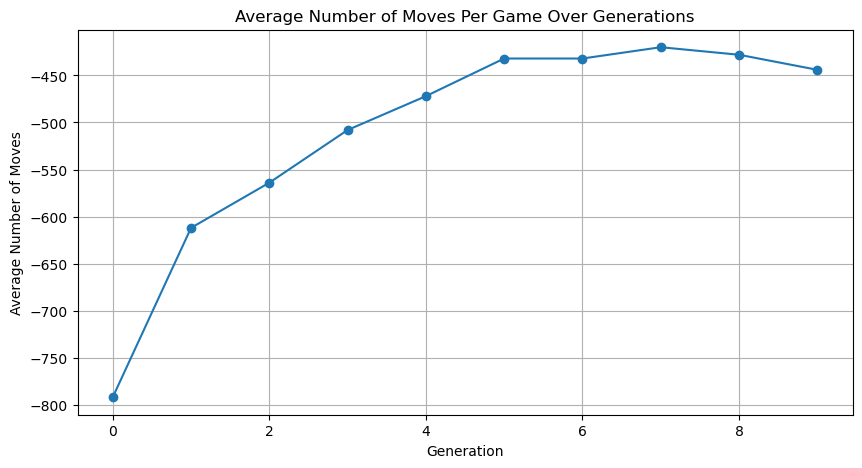

INFO:root:Initial state: <1 3 5 7>


Best agent index: 0
Best agent: [0.6184336229028635, 0.5142016857153865, 0.5278013506656338, 0.8287380209110751]
Tournament Setup:
pure_random vs gabriele
pure_random vs optimal
pure_random vs optimal_def
pure_random vs best_agent
gabriele vs optimal
gabriele vs optimal_def
gabriele vs best_agent
optimal vs optimal_def
optimal vs best_agent
optimal_def vs best_agent

Individual Match Results:
Match: pure_random vs gabriele - Winner: gabriele
Match: pure_random vs optimal - Winner: pure_random
Match: pure_random vs optimal_def - Winner: pure_random
Match: pure_random vs best_agent - Winner: best_agent
Match: gabriele vs optimal - Winner: gabriele
Match: gabriele vs optimal_def - Winner: gabriele
Match: gabriele vs best_agent - Winner: best_agent
Match: optimal vs optimal_def - Winner: optimal
Match: optimal vs best_agent - Winner: best_agent
Match: optimal_def vs best_agent - Winner: best_agent

Overall Tournament Standings:
pure_random: 2 wins
gabriele: 3 wins
optimal: 1 wins
optimal_d

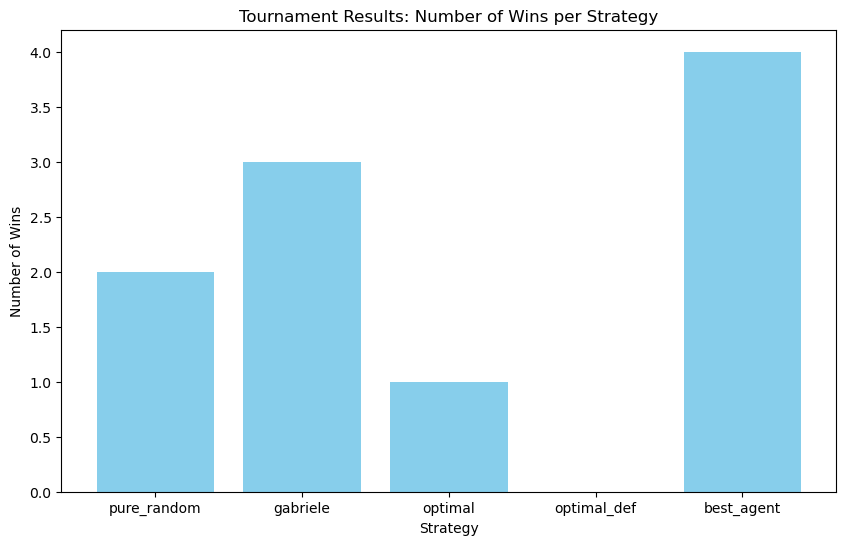

In [245]:
import logging
import matplotlib.pyplot as plt
import itertools

# Set the logging level to INFO to see the details of the game play
logging.getLogger().setLevel(logging.INFO)

# Set parameters for the evolutionary strategy
num_rows = 4  # number of rows in the Nim game
generations = 10  # number of generations to run the evolution
pop_size = 50  # size of the agent population
mutation_rate = 0.15  # mutation rate for the evolutionary strategy

# Initialize the Nim game
nim_game = Nim(num_rows)


# Run the evolutionary strategy to get a population of evolved agents
evolved_population, avg_moves_per_game_history = evolutionary_strategy(nim_game, generations, pop_size, mutation_rate)

# Plot the average number of moves per game over generations
plt.figure(figsize=(10, 5))
plt.plot(avg_moves_per_game_history, marker='o')
plt.title('Average Number of Moves Per Game Over Generations')
plt.xlabel('Generation')
plt.ylabel('Average Number of Moves')
plt.grid()
plt.show()

# Evaluate the final population to find the best agent from ES
fitness_scores = evaluate_population(evolved_population, nim_game)
best_agent_index = fitness_scores.index(max(fitness_scores))
print("Best agent index: " + str(best_agent_index))
best_agent = evolved_population[best_agent_index]
print("Best agent: " + str(best_agent.genome))

# Now let's play a game
nim = Nim(num_rows)
player = 0  # Let's say our expert system is player 0

strategies = {
    "pure_random": pure_random,
    "gabriele": gabriele,
    "optimal": optimal,
    "optimal_def": optimal_def,
    "best_agent": best_agent.make_move
}

logging.info(f"Initial state: {nim}")

def print_nim(nim):
    print("\nCurrent game state:")
    for row, num_objects in enumerate(nim.rows):
        print("Row {}: {}".format(row, "I" * num_objects))
    print("\n")

def play_game(strategy1, strategy2, num_rows):
    """Play a game of Nim between two strategies."""
    nim = Nim(num_rows)
    player = 0  # Start with player 0
    while nim:
        if player == 0:
            ply = strategy1(nim)
        else:
            ply = strategy2(nim)
        nim.nimming(ply)
        if not nim:
            return player  # Return the winning player
        player = 1 - player  # Switch player

# Setup tournament with available strategies
tournament_results = {name: 0 for name in strategies}  # Reinitialize scores
pairs = list(itertools.combinations(strategies.keys(), 2))  # List of all unique pairs of strategies

print("Tournament Setup:")
for pair in pairs:
    print(f"{pair[0]} vs {pair[1]}")

# Play matches and display individual match results
print("\nIndividual Match Results:")
for strategy1_name, strategy2_name in pairs:
    winner = play_game(strategies[strategy1_name], strategies[strategy2_name], num_rows)
    winning_strategy = strategy1_name if winner == 0 else strategy2_name
    tournament_results[winning_strategy] += 1
    print(f"Match: {strategy1_name} vs {strategy2_name} - Winner: {winning_strategy}")

# Overall Tournament Standings
print("\nOverall Tournament Standings:")
for strategy, wins in tournament_results.items():
    print(f"{strategy}: {wins} wins")


# Extracting strategy names and their respective win counts
strategies = list(tournament_results.keys())
wins = [tournament_results[strategy] for strategy in strategies]

# Creating a bar graph
plt.figure(figsize=(10, 6))
plt.bar(strategies, wins, color='skyblue')

# Adding titles and labels
plt.title('Tournament Results: Number of Wins per Strategy')
plt.xlabel('Strategy')
plt.ylabel('Number of Wins')

# Displaying the plot
plt.show()